In [2]:
import numpy as np
import random
import pandas as pd
import torch, os
from matplotlib import pyplot as plt
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from glob import glob
from tqdm import tqdm

In [35]:
import os, glob, shutil
import urllib.request as r
import kaggle 

def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "lentils"): 
    
    data_nomlari = ["salaries", "exams", "college", "cars", "mall", "customers", "humanitarian", 
                    "rice_leaf_disease", "lentils", "brain", "fruits", "aeroscapes", "cardiac"]
    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"
    
    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    elif data_nomi == "aeroscapes": url = "kaggle datasets download -d killa92/aerospaces-semantic-segmentation-dataset"
    elif data_nomi == "cardiac": url = "kaggle datasets download -d killa92/cardiac-semantic-segmentation-dataset"
    elif data_nomi == "brain": url = "kaggle datasets download -d killa92/brain-ct-tumor-classification-dataset"
    elif data_nomi == "fruits": url = "kaggle datasets download -d killa92/fruits-classification-dataset"
    
    # Download from the checkpoint path
    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

    # If the checkpoint does not exist
    else: 
        ds_nomi = url.split("/")[-1]
        full_path = f"{saqlash_uchun_papka}/{ds_nomi}"
        print(f"{data_nomi} dataset yuklanmoqda...")
        # Download the dataset
        os.system(f"{url} -p {full_path}")
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        os.remove(f"{full_path}/{ds_nomi}.zip")
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")
    
data_yuklab_olish(saqlash_uchun_papka = "brain_data", data_nomi = "brain")

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root, transformations = None, im_type = [".png", ".jpeg", ".jpg"]):
        super(). __init__()
        self.im_path = sorted(glob(f"{root}/*/*[{i for i  in im_type}]"))
        self.transformations = transformations
        self.class_dict = {}
        count = 0
        for idx, path in enumerate(self.im_path):
            image = self.get_class_func(path)
            if image not in self.class_dict: self.class_dict[image] = count; count+=1
   
    # classes 를 분류하는 함수
    def get_class_func(self, path):
        return os.path.dirname(path).split("\\")[-1]
        
    def __len__(self): return len(self.im_path)

    def __getitem__(self, idx):
        ims = self.im_path[idx] 
        im = Image.open(ims).convert('RGB')
        gt = self.class_dict[self.get_class_func(ims)]
        if self.transformations is not None: im =self.transformations(im)
        return im, gt
        
mean, std =[0.2250, 0.2250, 0.2250], [0.2505, 0.2505, 0.2505]
transformer = T.Compose([T.Resize((224, 224)),
                        T.ToTensor(),
                        T.Normalize(mean =mean, std =std)])


root = "brain_data/brain/brain/images"
data = CustomDataset(root =root, transformations=transformer)
classes = data.class_dict
data[1]
classes

{'aneurysm': 0, 'cancer': 1, 'tumor': 2}

In [4]:
tottal = len(data)
split = [0.8, 0.1, 0.1]
tr_len = int(tottal*split[0])
ts_len = int(tottal*split[1])
val_len= tottal-(tr_len+ts_len)
tr_ds, ts_ds, val_ds = random_split(dataset=data, lengths=[tr_len, ts_len, val_len ])

print(tr_len)
print(ts_len)
print(val_len)
print("\n")
bs =16
tr_dl = DataLoader(dataset = tr_ds, batch_size = bs,  shuffle = True, num_workers = 0)
val_dl = DataLoader(dataset = tr_ds, batch_size = bs , shuffle = True, num_workers = 0)
ts_dl = DataLoader(dataset = tr_ds, batch_size =1 ,  shuffle = True, num_workers = 0)
print(len(tr_dl))
print(len(val_dl))
print(len(ts_dl))

207
25
27


13
13
207


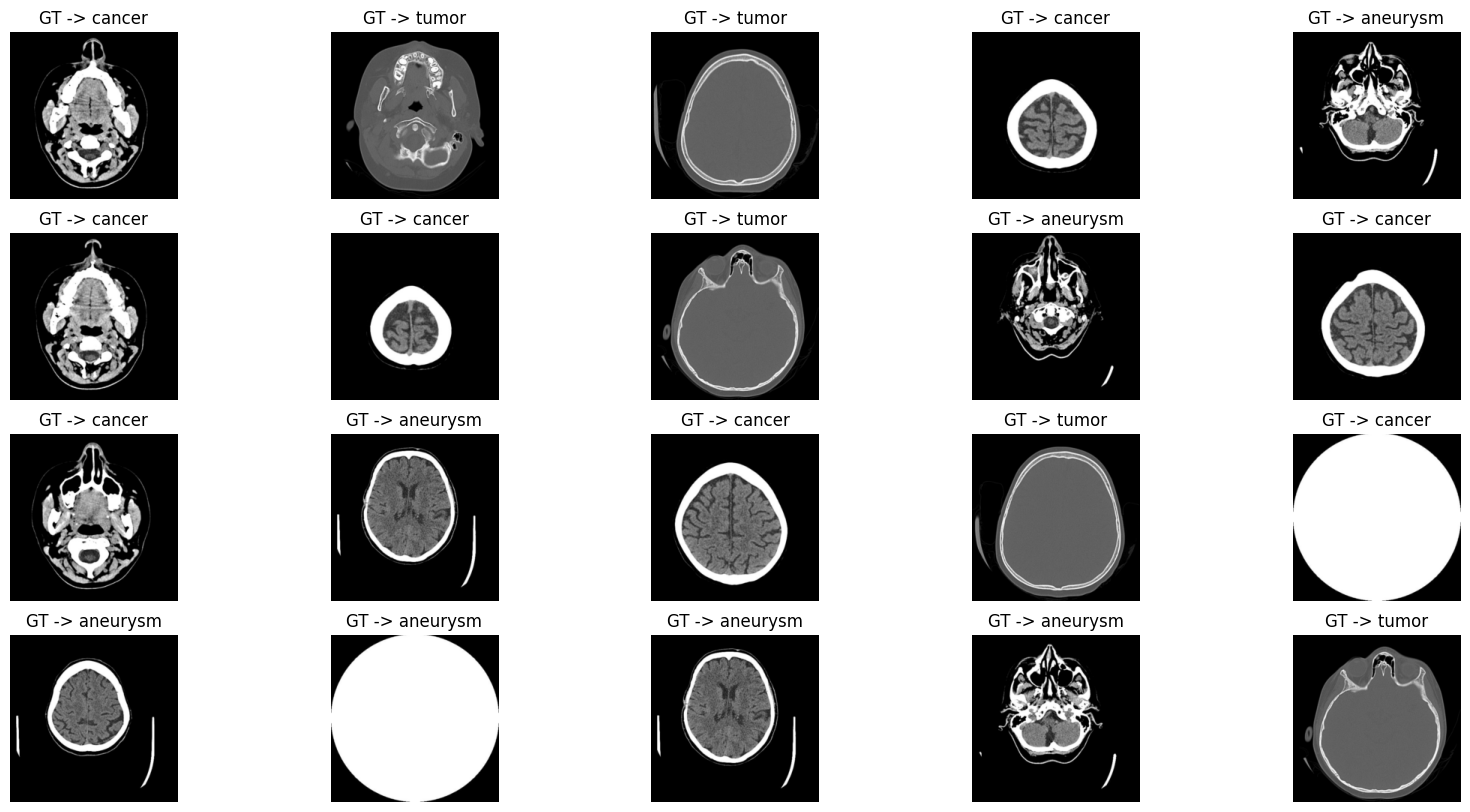

In [5]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):
    
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.2505, 1/0.2505, 1/0.2505]),
                         T.Normalize(mean = [ -0.2250, -0.2250, -0.2250 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs 
    
    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):
    
    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "RdBu"
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):
        
        im, gt = data[indeks]
        
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, "RdBu"), cmap="RdBu")
        else: plt.imshow(tensor_2_im(im))

        
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[gt]}")
        else: plt.title(f"GT -> {gt}")
            
visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

In [ ]:
!pip install timm

In [6]:
import timm
model = timm.create_model(model_name="rexnet_150", pretrained=True, num_classes = len(classes))
device = "cuda" if torch.cuda.is_available() else 'cpu'
loss_fn = torch.nn.CrossEntropyLoss()
optimazer  = torch.optim.Adam(params=model.parameters(), lr=3e-4)
model.to(device)

RexNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (features): Sequential(
    (0): LinearBottleneck(
      (conv_dw): ConvNormAct(
        (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
      (act_dw): ReLU6()
      (conv_pwl): ConvNormAct(
        (conv): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
    )
    (1): LinearBottlene

In [7]:
def train(model, tr_data, val_data, opt, loss_fn, device, epocs, threshold, save_prefix):
    tr_acc_sc, tr_epoc_loss, val_acc_sc, val_epoc_loss = [],[],[],[]
    best_loss = np.inf
    print("Train progress is starting ........")
    
    for epoc in range(epocs):
        print(f"{epoc+1} - epoc is starting ...")
        tr_acc, tr_loss, tr_total =0,0,0
        for idx, batch in enumerate(tqdm(tr_data)):
            im, gt = batch
            im, gt = im.to(device), gt.to(device)
            tr_total+=im.shape[0]
            # predict using the model
            pred = model(im)
            # Culculate Loss using the loss function
            loss =loss_fn(pred, gt)
            #update the training loss 
            tr_loss+=loss.item()
            # get indeces of the maximum values in the predictions 
            pred_class = torch.argmax(pred, dim =1)
            # Culculate the train accurancy scores
            tr_acc+=(pred_class==gt).sum().item()

            # preform optimizetion steps
            
            opt.zero_grad()
            loss.backward()
            opt.step()
        tr_acc /=len(tr_data.dataset)
        tr_loss /= len(tr_data)
        tr_acc_sc.append(tr_acc)
        tr_epoc_loss.append(tr_loss)

        # Validation progress
        # Set the model to evaluation mode
        model.eval()
        # Perform inference or validation without computing gradients
        with torch.no_grad():
            val_acc, val_loss, val_total =0,0,0
            for idx, batch in enumerate(tqdm(val_data)):
                im, gt = batch
                im, gt = im.to(device), gt.to(device)
                val_total+=im.shape[0]
                #predict using the model
                pred = model(im)
                # Culculate Loss using the loss function
                loss = loss_fn(pred, gt)
                # update validation loss
                val_loss+=loss.item()
                # get indeces of the maximum values in predictions
                pred_class =torch.argmax(pred, dim =1)
                # Culculate the validation accurancy scores
                val_acc+=(pred_class==gt).sum().item()
            
            val_acc /= len(val_data.dataset)
            val_loss /=len(val_data)
            val_acc_sc.append(val_acc)
            val_epoc_loss.append(val_loss)
            
            print(f"{epoc+1} - epoc Train process is results:\n")
            print(f"{epoc+1} - epoc Train Accurancy score       - > {tr_acc:.3f}")
            print(f"{epoc+1} - epoc Train epoc loss  score      - > {tr_loss:.3f}")
            print(f"{epoc+1} - epoc Validation process is results:\n")
            print(f"{epoc+1} - epoc Validation Accurancy score  - > {val_acc:.3f}")
            print(f"{epoc+1} - epoc Validation epoc loss  score - > {val_loss:.3f}")
            
            if val_loss < (best_loss + threshold):
                val_loss = best_loss
                os.makedirs("brain_best_model", exist_ok=True)
                torch.save(model, f"brain_best_model/{save_prefix}_best_model.pht")
                
    return {"tr_acc_sc": tr_acc_sc, "tr_epoc_loss": tr_epoc_loss, "val_acc_sc": val_acc_sc, "val_epoc_loss": val_epoc_loss}

result = train(model= model.to(device).eval(), tr_data =tr_dl, val_data = val_dl, opt = optimazer, 
               loss_fn = loss_fn, device =device, epocs =10, threshold = 0.001, save_prefix = "Brain")

Train progress is starting ........
1 - epoc is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.72it/s]


1 - epoc Train process is results:

1 - epoc Train Accurancy score       - > 0.623
1 - epoc Train epoc loss  score      - > 2.232
1 - epoc Validation process is results:

1 - epoc Validation Accurancy score  - > 0.855
1 - epoc Validation epoc loss  score - > 0.257
2 - epoc is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.33it/s]


2 - epoc Train process is results:

2 - epoc Train Accurancy score       - > 0.961
2 - epoc Train epoc loss  score      - > 0.131
2 - epoc Validation process is results:

2 - epoc Validation Accurancy score  - > 0.981
2 - epoc Validation epoc loss  score - > 0.079
3 - epoc is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.38it/s]


3 - epoc Train process is results:

3 - epoc Train Accurancy score       - > 0.981
3 - epoc Train epoc loss  score      - > 0.051
3 - epoc Validation process is results:

3 - epoc Validation Accurancy score  - > 0.990
3 - epoc Validation epoc loss  score - > 0.020
4 - epoc is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.03it/s]


4 - epoc Train process is results:

4 - epoc Train Accurancy score       - > 0.990
4 - epoc Train epoc loss  score      - > 0.032
4 - epoc Validation process is results:

4 - epoc Validation Accurancy score  - > 0.990
4 - epoc Validation epoc loss  score - > 0.031
5 - epoc is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.50it/s]


5 - epoc Train process is results:

5 - epoc Train Accurancy score       - > 0.990
5 - epoc Train epoc loss  score      - > 0.037
5 - epoc Validation process is results:

5 - epoc Validation Accurancy score  - > 0.981
5 - epoc Validation epoc loss  score - > 0.024
6 - epoc is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.21it/s]


6 - epoc Train process is results:

6 - epoc Train Accurancy score       - > 0.986
6 - epoc Train epoc loss  score      - > 0.029
6 - epoc Validation process is results:

6 - epoc Validation Accurancy score  - > 0.995
6 - epoc Validation epoc loss  score - > 0.014
7 - epoc is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.58it/s]


7 - epoc Train process is results:

7 - epoc Train Accurancy score       - > 0.995
7 - epoc Train epoc loss  score      - > 0.019
7 - epoc Validation process is results:

7 - epoc Validation Accurancy score  - > 0.995
7 - epoc Validation epoc loss  score - > 0.013
8 - epoc is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.71it/s]


8 - epoc Train process is results:

8 - epoc Train Accurancy score       - > 0.981
8 - epoc Train epoc loss  score      - > 0.025
8 - epoc Validation process is results:

8 - epoc Validation Accurancy score  - > 0.995
8 - epoc Validation epoc loss  score - > 0.013
9 - epoc is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.59it/s]


9 - epoc Train process is results:

9 - epoc Train Accurancy score       - > 0.995
9 - epoc Train epoc loss  score      - > 0.013
9 - epoc Validation process is results:

9 - epoc Validation Accurancy score  - > 0.995
9 - epoc Validation epoc loss  score - > 0.015
10 - epoc is starting ...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 10.43it/s]

10 - epoc Train process is results:

10 - epoc Train Accurancy score       - > 0.995
10 - epoc Train epoc loss  score      - > 0.017
10 - epoc Validation process is results:

10 - epoc Validation Accurancy score  - > 0.995
10 - epoc Validation epoc loss  score - > 0.012


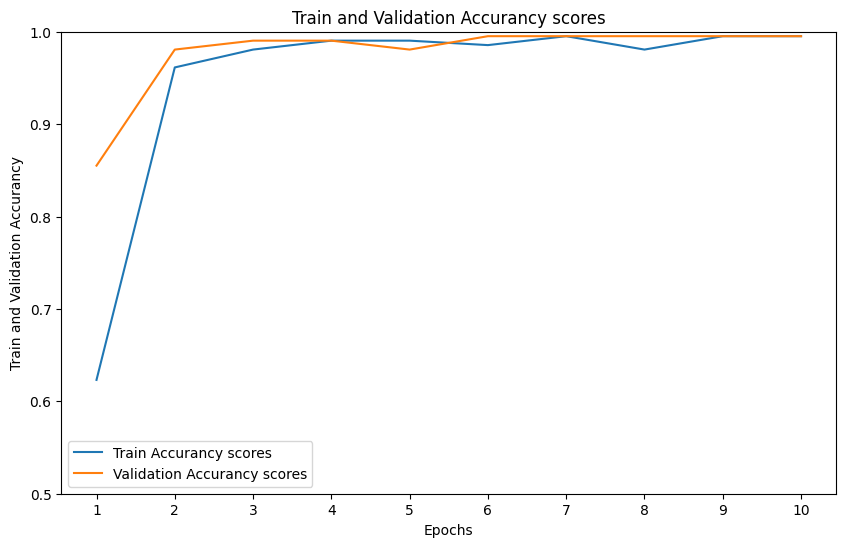

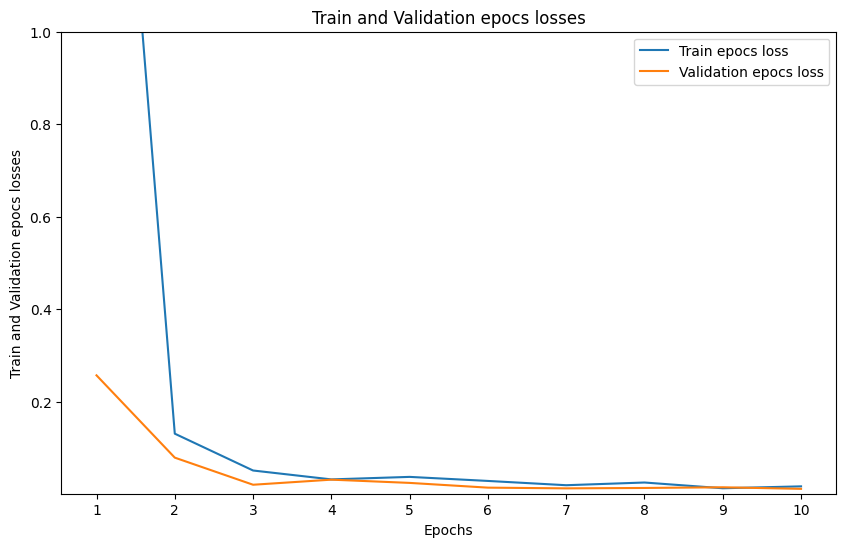

In [8]:
class plot():
    def __init__(self, r):
        plt.figure(figsize=(10, 6))
        plt.plot(r["tr_acc_sc"], label ="Train Accurancy scores")
        plt.plot(r["val_acc_sc"], label = "Validation Accurancy scores")
        plt.title("Train and Validation Accurancy scores")
        plt.xlabel("Epochs")
        plt.ylabel("Train and Validation Accurancy")
        plt.xticks(np.arange(len(r["val_acc_sc"])), [i for i in range(1, len(r["val_acc_sc"])+1)])
        plt.legend()
        plt.ylim(0.5 ,1)
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(r["tr_epoc_loss"], label ="Train epocs loss")
        plt.plot(r["val_epoc_loss"], label = "Validation epocs loss")
        plt.title("Train and Validation epocs losses")
        plt.xlabel("Epochs")
        plt.ylabel("Train and Validation epocs losses")
        plt.xticks(np.arange(len(r["val_acc_sc"])), [i for i in range(1, len(r["val_acc_sc"])+1)])
        plt.legend()
        plt.ylim(0.001 ,1)
        plt.show()
        
        
  
plot(result) 

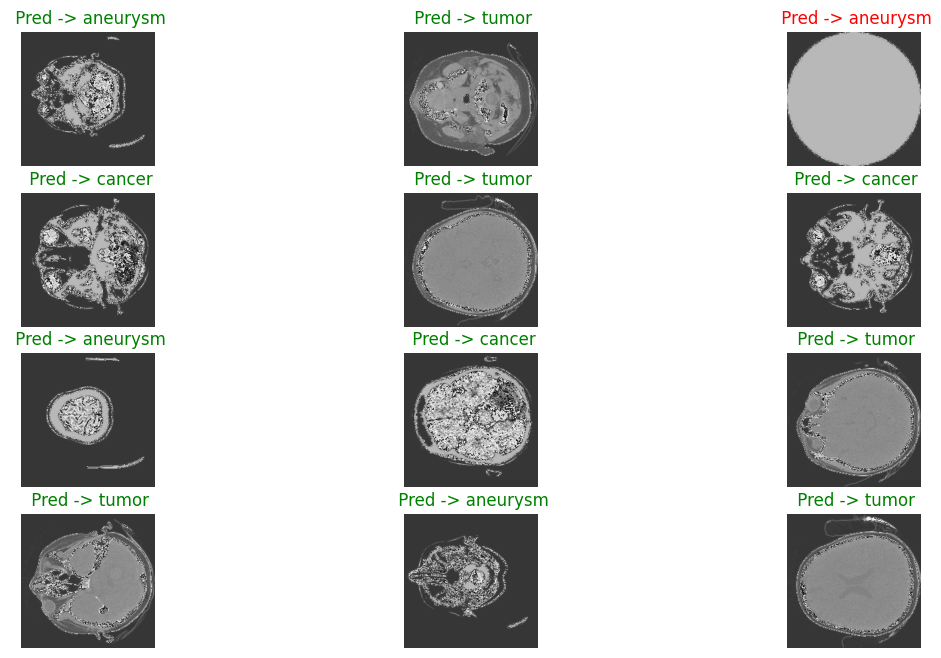

In [9]:
import torch
import matplotlib.pyplot as plt

def inference(data, model, device, number_im, images_per_row, class_name=None):
    ims, preds = [], []
    for idx, batch in enumerate(data):
        if idx == number_im:
            break
        im = batch
        ims.append(im)
        pred = torch.argmax(model(im[0].unsqueeze(dim=0).to(device)), dim=1).item()
        preds.append(pred)

    plt.figure(figsize=(14, 8))
    for row in range(0, number_im, images_per_row):
        for cal in range(images_per_row):
            index = cal + row
            if index < number_im:
                im = ims[index]
                plt.subplot(number_im // images_per_row, images_per_row, index + 1)
                plt.imshow((im[0].cpu() * 225).permute(2, 1, 0).numpy().astype("uint8"))
                plt.axis("off")
                if class_name is not None:
                    title_color = 'green' if class_name[preds[index]] == class_name[im[1]] else 'red'
                    plt.title(f" Pred -> {class_name[preds[index]]}", color=title_color)
                else:
                    plt.title(f"Prediction: {preds[index]}")
    plt.show()
    
# Assuming you have defined classlar and ts_ds
model = torch.load("Brain_best_model/brain_best_model.pht") 
inference(data=ts_ds, model=model, device=device, number_im=12, class_name=list(classes.keys()), images_per_row=3)


In [12]:
save_prefix, save_dir = "lentils", "saved_models"

In [13]:
# test Accurency Score
acc = 0
for ind, path in enumerate(ts_dl):
    im, gt = path
    im, gt = im.to(device), gt.to(device)
    pred = torch.argmax(model(im), dim=1)
    acc+=(pred==gt).sum().item()
print(f"Accuracy of the model on the test dataset is -> {(acc / len(ts_dl.dataset)):.3f}")    

Accuracy of the model on the test dataset is -> 0.995


207it [00:04, 46.33it/s]


Accuracy of the model on the test data -> 0.981


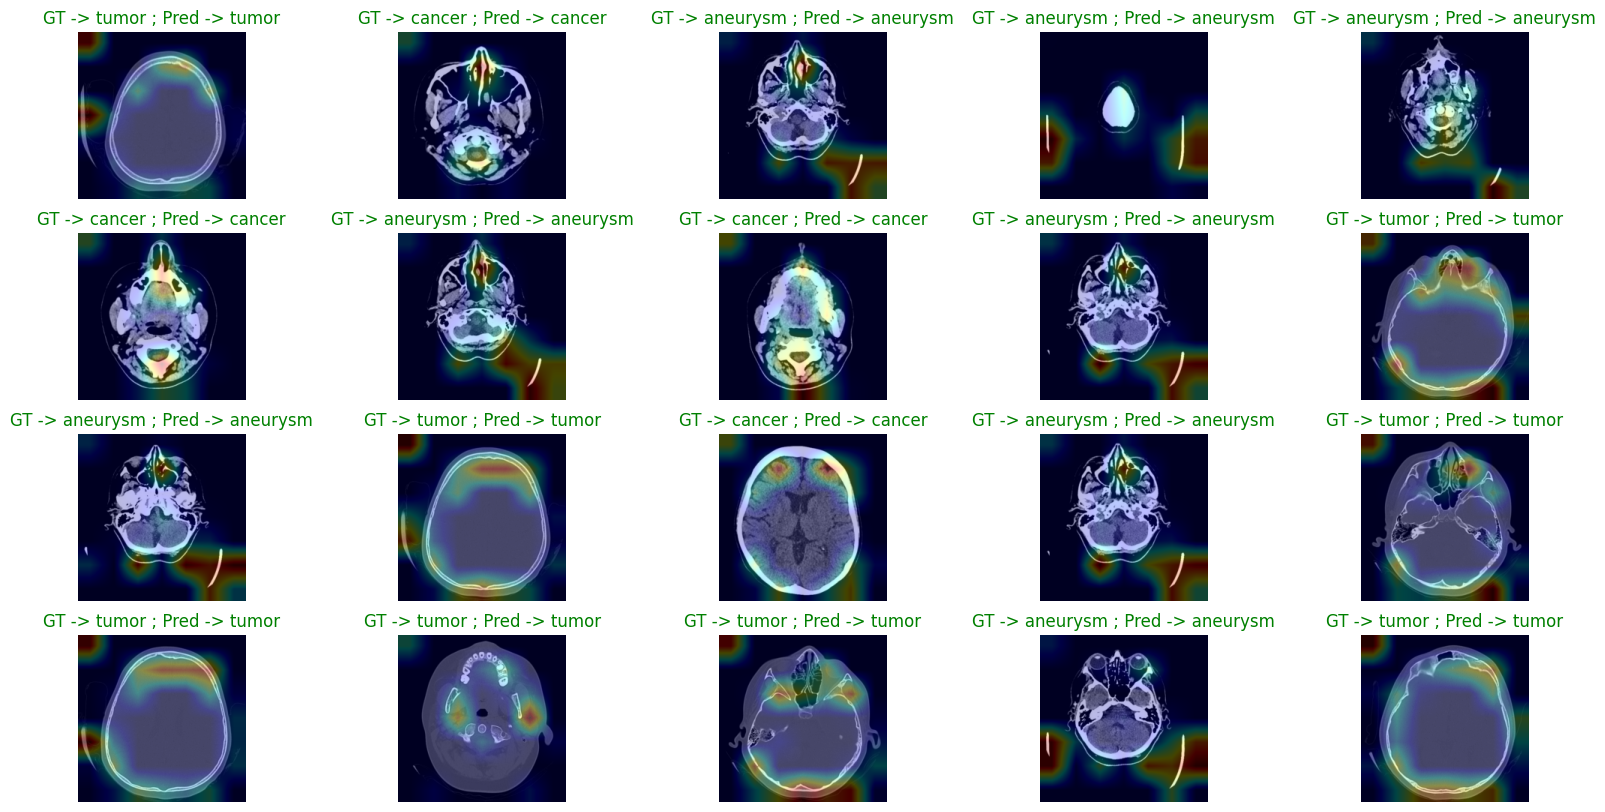

In [15]:
import cv2
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image

def inference(model, device, test_dl, num_ims, row, klass_nomlari = None, rasm_hajmi = None):
    
    # Accuracy hisoblash uchun o'zgaruvchi
    aniqlilik = 0
    # Listlarni yaratib olamiz
    hamma_bashoratlar, hamma_rasmlar, hamma_javoblar = [], [], []
    for idx, batch in tqdm(enumerate(test_dl)):
        # if idx == 3: break
        # har bir batchda (batch sizega teng bo'lgan) rasm va javoblar bor
        rasmlar, javoblar = batch
        rasmlar, javoblar = rasmlar.to(device), javoblar.to(device)
        # argmax (eng katta qiymat turgan indeksni qaytaradi) da dim = 1 olishimning sababi logits lar bo'yicha qaytaradi
        bashoratlar = torch.argmax(model(rasmlar), dim = 1)
        aniqlilik += (bashoratlar == javoblar).sum().item()
        hamma_rasmlar.append(rasmlar)
        hamma_bashoratlar.append(bashoratlar.item())
        hamma_javoblar.append(javoblar.item())
    
    print(f"Accuracy of the model on the test data -> {(aniqlilik / len(test_dl.dataset)):.3f}")
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(hamma_rasmlar) - 1) for _ in range(num_ims)]
    
    for idx, indeks in enumerate(indekslar):
        
        # triplet - 3 ta; pair - 2ta
        rasm = hamma_rasmlar[indeks].squeeze()
        javob = hamma_javoblar[indeks]; bashorat = hamma_bashoratlar[indeks]
        
        # GradCAM -> array (CPU) lar bilan ishlaydi;
        orig_rasm = tensor_2_im(rasm) / 255
        
        cam = GradCAMPlusPlus(model = model, target_layers = [model.features[-1]])
        # print(cam(input_tensor = rasm.unsqueeze(0)).shape)
        # print(cam(input_tensor = rasm.unsqueeze(0))[0, :].shape)
        grayscale_cam = cam(input_tensor = rasm.unsqueeze(0))[0, :]
        heatmap = show_cam_on_image(img = orig_rasm, mask = grayscale_cam, image_weight = 0.1, use_rgb = True)
        
        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(rasm), cmap = "gray"); plt.axis("off")
        plt.imshow(cv2.resize(heatmap, (rasm_hajmi, rasm_hajmi), interpolation = cv2.INTER_LINEAR), alpha = 0.3, cmap = "jet"); plt.axis("off")
        
        rang = ("green" if {klass_nomlari[int(javob)]} == {klass_nomlari[int(bashorat)]} else "red")
        if klass_nomlari: plt.title(f"GT -> {klass_nomlari[javob]} ; Pred -> {klass_nomlari[bashorat]}", color = rang)
        else: plt.title(f"GT-> {javob} ; Pred -> {bashorat}")
        
model.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
model.eval()
inference(model = model.to(device), device = device, test_dl = ts_dl, num_ims = 20, row = 4, klass_nomlari = list(classes.keys()), rasm_hajmi = 224)